# Clustering pipeline for JunoCam images
Given a JunoCam image, we want to be able to segregate the different types by color. With this, the goal is to produce useful statistics on the presence of different cloud classes at different locations and relate the cloud type to the dynamics of that region. 

To begin, first import the `ImageCluster` class which will be the main driver for this task

In [1]:
from clustering import ImageCluster

This class is initialized with just the raw map-projected JunoCam image (see the example in `projection.ipynb` on how to do this).

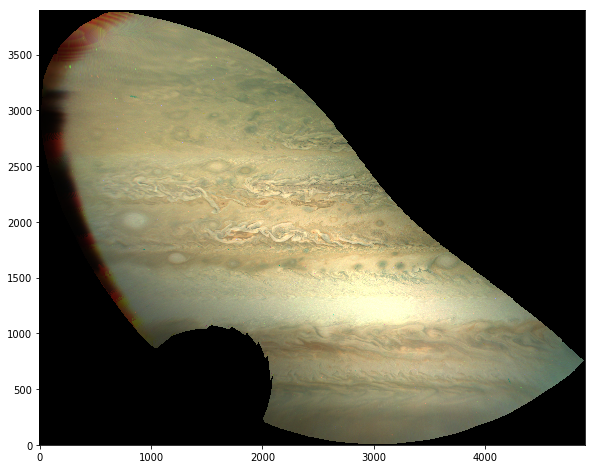

In [2]:
clust = ImageCluster('JNCE_2018302_16C00024_V01_mosaic_RGB.png')

Do the clustering using the KMeans method. The input arguments are:

* `n_clusters`: The number of clusters to detect

* `source`: Either 'rgb' or 'hsv'. With RGB we can cluster raw pixel values, or with HSV, we can cluster colors directly. 

* `axis`: Tuple of length 2, that defines the two components to cluster. e.g. using RGB, (0,1) would be R and G, while with HSV, (0,1) would be Hue vs. Saturation

In [3]:
clust.create_clusters(n_clusters=5)

Once the clustering is done, we can plot some useful info

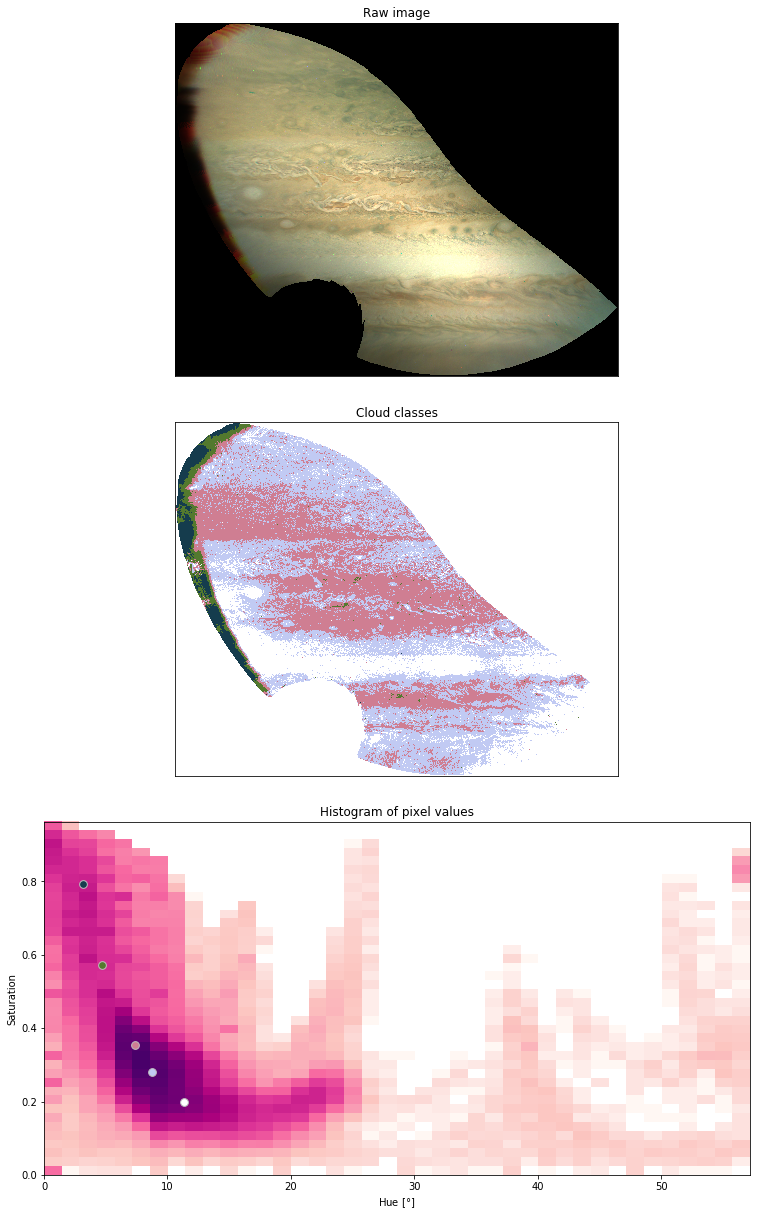

In [4]:
clust.plot_clusters()

Notice how the green classes are actually being detected on the interpolation errors. These are not useful for us, so we can remove them. The cluster labels are ordered from dark to light, starting from 1 to `n_clusters` defined above. They are also ordered in increasing x. So we want to remove the pixels associated with `label=1` and `label=2`. We can do this using the `filter_cluster` method:

In [5]:
clust.filter_cluster(1)
clust.filter_cluster(2)

Removed 259060 pixels
Removed 242781 pixels


Now, rerun again with the removed data:

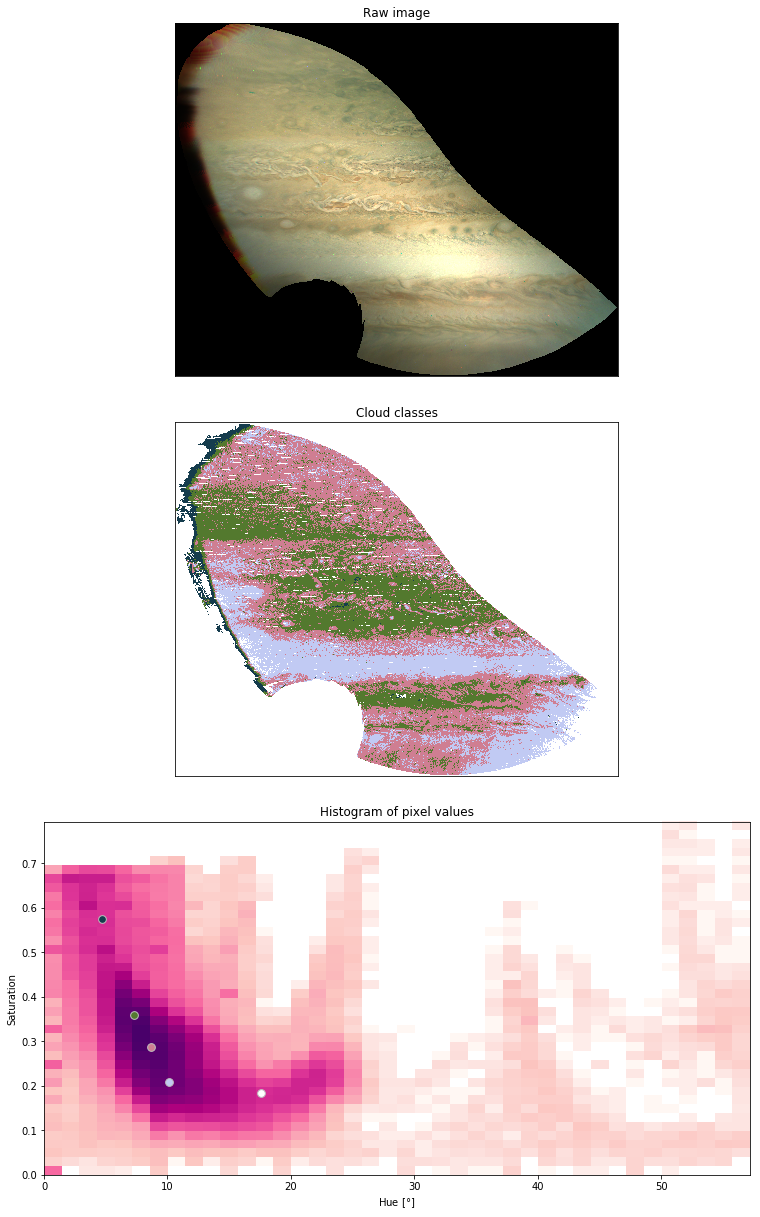

In [6]:
clust.create_clusters(n_clusters=5)
clust.plot_clusters()

Time to do some statistics. We can look at the correlation between cloud class and latitude. This will highlight the different bands on Jupiter